In [24]:
from utils.video_dataset import VideoFrameDataset
from config.torch_config import get_transform, device, normalize
from config.dataset import get_dataset_path


In [25]:
NUM_SEGMENTS = 1
FRAMES_PER_SEGMENT = 10
BATCH_SIZE = 4
IMAGE_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001


In [26]:
data_path, model_path = get_dataset_path(dataset="signs")
multiple_transform = get_transform(IMAGE_SIZE)


In [27]:
dataset = VideoFrameDataset(
    root_path=data_path,
    transform=multiple_transform,
    num_segments=NUM_SEGMENTS,
    frames_per_segment=FRAMES_PER_SEGMENT,
)

classes = dataset.classes


In [28]:
from utils.loader import split_dataset


In [29]:
train_loader, test_loader, validation_loader = split_dataset(
    dataset, train_split=0.7, validation_split=0.2, batch_size=BATCH_SIZE
)


In [30]:
print(len(train_loader), len(validation_loader), len(test_loader))


1 1 1


### Example of input of net.

> Initial input = [BATCH_SIZE, NUMBER_OF_FRAMES, CHANNELS, HEIGHT, WIDTH]

This example shows first example (first video) in first batch

In [31]:
from utils.output import plot_tensor
from torchvision.utils import make_grid
from torch import nn


In [32]:
def plot_grid(
    tensor, dims=(1, 2, 0), nrow=FRAMES_PER_SEGMENT*NUM_SEGMENTS, norm=True, start_dim=0, end_dim=1
):
    flat = nn.Flatten(start_dim=start_dim, end_dim=end_dim) # Flatten batch to plot.

    flatted_tensor = flat(tensor)
    grid = make_grid(flatted_tensor.cpu(), nrow=nrow)

    if norm:
        grid = normalize(grid)

    plot_tensor(grid, dims)


### Show input of the net (entire batch)

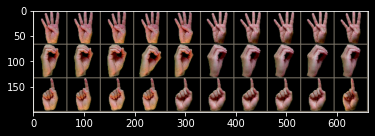

In [33]:
first_batch = next(iter(train_loader))[0]
plot_grid(first_batch)

### The net will then make first and second convolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


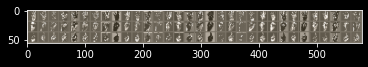

torch.Size([3, 32, 1, 16, 16])

In [34]:
hidden_1, hidden_2 = 16, 32

conv1 = nn.Conv3d(FRAMES_PER_SEGMENT*NUM_SEGMENTS, hidden_1, kernel_size=3, stride=2, padding=1)
conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, stride=2, padding=1)
relu = nn.LeakyReLU()
batch_1 = nn.BatchNorm3d(hidden_1)
batch_2 = nn.BatchNorm3d(hidden_2)

x = first_batch

x = conv1(x)
x = relu(x)
x = batch_1(x)

x = conv2(x)
x = relu(x)
x = batch_2(x)

plot_grid(x, nrow=hidden_2)

x.shape

## Check balance status of the loaders

In [35]:
# from utils.balance import check_balance_status

# check_balance_status(test_loader, classes)
# check_balance_status(train_loader, classes)


In [36]:
from lib.model import resnet34 as resnet

model = resnet(sample_duration=FRAMES_PER_SEGMENT*NUM_SEGMENTS, sample_size=IMAGE_SIZE, num_classes=len(classes))


In [37]:
# from lib.simple_model import HPNet

# model = HPNet(
#     num_classes=len(classes),
#     batch_size=BATCH_SIZE,
#     num_frames=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
#     image_size=IMAGE_SIZE,
# )

# model


In [38]:
from lib.train import train_model


In [39]:
train_costs, val_costs = train_model(
    model,
    train_loader,
    validation_loader,
    device,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
)


Training on device: cuda
Train cost at epoch 1 is 1.77786
Validation cost at epoch 1 is 669.08246
Train cost at epoch 2 is 0.56838
Validation cost at epoch 2 is 1819.74182
Train cost at epoch 3 is 0.00351
Validation cost at epoch 3 is 3176.15039
Train cost at epoch 4 is 0.00217
Validation cost at epoch 4 is 4207.19434
Train cost at epoch 5 is 0.00239
Validation cost at epoch 5 is 4664.23389
Train cost at epoch 6 is 0.00257
Validation cost at epoch 6 is 4688.14941
Train cost at epoch 7 is 0.00223
Validation cost at epoch 7 is 4427.29297
Train cost at epoch 8 is 0.00183
Validation cost at epoch 8 is 4009.98438
Train cost at epoch 9 is 0.00168
Validation cost at epoch 9 is 3547.43970
Train cost at epoch 10 is 0.00155
Validation cost at epoch 10 is 3096.08838
Train cost at epoch 11 is 0.00134
Validation cost at epoch 11 is 2679.32544
Train cost at epoch 12 is 0.00110
Validation cost at epoch 12 is 2303.78589
Train cost at epoch 13 is 0.00088
Validation cost at epoch 13 is 1972.03931
Train 

### Normalize costs between 0 and 1

In [ ]:
from utils.output import plot_costs

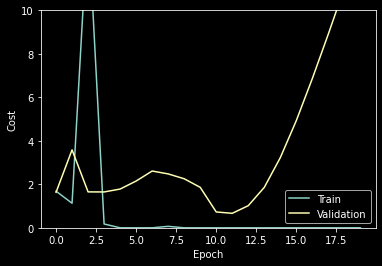

In [ ]:
plot_costs(train_costs, val_costs)


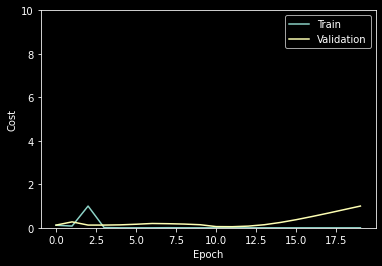

In [ ]:
# Normalized costs. Does not represent real cost values.
plot_costs(train_costs, val_costs, normalize_data=True)


In [ ]:
from lib.test import check_accuracy


In [ ]:
check_accuracy(train_loader, model, classes, device)


Predictions for batch 1 
['4', '4', '4']
Ground truth for batch 1
['3', '0', '4']
---------------------------------


Got 1 / 3 with accuracy 33.33


In [ ]:
check_accuracy(test_loader, model, classes, device)

Predictions for batch 1 
['4']
Ground truth for batch 1
['1']
---------------------------------


Got 0 / 1 with accuracy 0.00


In [ ]:
check_accuracy(validation_loader, model, classes, device)

Predictions for batch 1 
['4']
Ground truth for batch 1
['2']
---------------------------------


Got 0 / 1 with accuracy 0.00
